In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from PIL import Image, ImageDraw, ImageFont
from library.analysis import testSets, generators

# Constants

In [2]:
kScore = "cohens kappa score"
f1Score = "f1 score"

kScoreSd = kScore + " - SD"
f1ScoreSd = f1Score + " - SD"

# Settings

In [3]:
ignoreSet = ["ozone_level", "yeast_me2"]

gans = [g.replace("SimpleGAN", "GAN") for g in generators.keys()][:-1]
algs = ["LR", "RF", "GB", "KNN", "DoC"]

In [4]:
testSets = [t for t in testSets if t[0:7] == "folding"]

In [5]:
def cleanupName(name):
    return name.replace("folding_", "").replace("imblearn_", "").replace("kaggle_", "")

In [6]:
dataset = [cleanupName(d) for d in testSets]

In [7]:
def ganName(name):
    return name.replace(
        "ConvGeN-majority-5", "ConvGeN(5,maj)").replace(
        "ConvGeN-majority-full", "ConvGeN(min,maj)").replace(
        "ConvGeN-proximity-5", "ConvGeN(5,prox)").replace(
        "ConvGeN-proximity-full", "ConvGeN(min,prox)")

In [8]:
def filterConvGen(name):
    return not name.startswith("ConvGeN") or name == "ConvGeN(min,maj)"

# Load data from CSV files

In [9]:
def loadDiagnoseData(ganType, datasetName):
    fileName = f"data_result/{ganType}/{datasetName}.csv"
    r = {}
    try:
        f1List = []
        kList = []
        indizes = [str(x) for x in range(100)]
        with open(fileName) as f:
            newBlock = True
            n = ""
            for line in f:
                line = line.strip()
                if newBlock:
                    n = line
                    if n == "GAN" or n == "DoG":
                        n = "DoC"
                    newBlock = False
                elif line == "---":
                    newBlock = True
                    f1List = []
                    kList = []
                else:
                    parts = line.split(";")
                    if parts[0] == "avg":
                        f1Avg = float(parts[5])
                        f1Sd = math.sqrt(sum([(f1Avg - x)*(f1Avg - x) for x in f1List]) / len(f1List))
                        kAvg = float(parts[6])
                        kSd = math.sqrt(sum([(kAvg - x)*(kAvg - x) for x in kList]) / len(kList))
                        r[n] = { f1Score: f1Avg, kScore: kAvg, f1ScoreSd: f1Sd, kScoreSd: kSd }
                    elif parts[0] in indizes:
                        f1List.append(float(parts[5]))
                        kList.append(float(parts[6]))
    except FileNotFoundError as e:
        print(f"Missing file: {fileName}")
    return r

In [10]:
statistic = { }

for gan in gans:
    if ganName(gan) not in statistic:
        statistic[ganName(gan)] = {}
    
    for ds in testSets:
        if ds != "Average":
            statistic[ganName(gan)][cleanupName(ds)] = loadDiagnoseData(gan, ds)
            
            d = cleanupName(ds)
            if d not in dataset:
                dataset.append(d)

gans = list(statistic.keys())

In [11]:
for gan in gans:
    f1 = { n: 0.0 for n in algs }
    k =  { n: 0.0 for n in algs }
    f1Sd = { n: 0.0 for n in algs }
    kSd =  { n: 0.0 for n in algs }
    c = 0

    for ds in dataset:
        if ds != "Average":
            c += 1
            for n in algs:
                if n in statistic[gan][ds].keys():
                    f1[n] += statistic[gan][ds][n][f1Score]
                    k[n] += statistic[gan][ds][n][kScore]
                    f1Sd[n] += statistic[gan][ds][n][f1ScoreSd]
                    kSd[n] += statistic[gan][ds][n][kScoreSd]

    avg = {}
    for n in algs:
        avg[n] = { f1Score: f1[n] / c, f1ScoreSd: f1Sd[n] / c, kScore: k[n] / c, kScoreSd: kSd[n] / c }
    statistic[gan]["Average"] = avg

# Show Statistics

In [12]:
def drawTransparentRect(img, rect, color, opacity=1.0):
    def mix(v, a, b):
        return max(0, min(255, int((v * a) + ((1.0 - v) * b))))

    def mixPixel(v, a, b):
        return (mix(v, a[0], b[0]), mix(v, a[1], b[1]), mix(v, a[2], b[2]))


    ((x0, y0), (x1, y1)) = rect
    
    for y in range(y0, y1):
        for x in range(x0, x1):
            p = (x, y)
            c = mixPixel(opacity, color, img.getpixel(p))
            img.putpixel(p, c)
    

In [13]:
def drawDiagram(size, rowNames, data, colNames=[], colors=None, border=20, barIndent=10, fontSize=20, markers=[0.25, 0.5, 0.75, 1.00], maxY=1.0):
    silver = (204, 204, 204)
    black = (0,0,0)
    white = (255, 255, 255)
    
    defaultColors = [ (31,119,180)
                    , (255,127,14)
                    , (44,160,44)
                    , (214,40,40)
                    , (148,103,189)
                    , (140,86,75)
                    , (227,119,194)
                    , (127,127,127)
                    , (40,40,214)
                    ]

    defaultColors = [ (209,188,115) # Gold
                    , (145,196,223) # bright blue
                    , (83,119,202)  # blue
                    , (224,138,86)  # orange
                    , (131,202,112) # green
                    , (199,102,99)  # red
                    , (143,110,176) # violet
                    , (134,99,66)   # brown
                    , (207,131,189) # pink
                    ]
    
    def y(v):
        return v / maxY

    def med(v):
        if type(v) is tuple:
            return v[0]
        return v

    
    if colors is None:
        colors = defaultColors

    print((len(data[0]), len(colNames), len(data), len(rowNames)))

    font = ImageFont.truetype("FreeSans", fontSize)
    
    markerSize = 0
    for m in markers:
        markerSize = max(markerSize, font.getsize(f"{m:0.2f}")[0])

    areaTop = 2 * border + markerSize

    barStep = (size[0] - border - areaTop) // len(data)
    barSize = max(border, barStep - border)
    barIndent = min(barIndent, barSize / (1 + len(data[0])))
    barIndent = barSize / (2 + len(data[0]))
    
    print((size[0], barSize, barSize * len(data)))
    
    # Create new Image
    w = max(size[0], size[1])
    img = Image.new("RGB", (w,w))
    d = ImageDraw.Draw(img)
    
    # Set background to white.
    d.rectangle(((0,0), (w,w)), fill=white)
    
    # draw row names
    height = size[1]
    left = w - height
    textSize = 0
    for (n, name) in enumerate(rowNames):
        s = font.getsize(name)
        offset = int(border + barSize - s[1] + 1.5) // 2
        textSize = max(textSize, s[0])
        pos = (left + border, areaTop + offset + (barStep * n))
        d.text(pos, name, fill=black, font=font)
        
        
    # Calculate sizes for bar drawing.
    barLength = height - (4 * border) - textSize
    areaSize = (barLength, barSize)
    areaLeft = left + (2 * border) + textSize
    
    # Draw Lines for bar height comparing.
    markerPos = [areaLeft + int(y(v) * barLength) for v in markers]
    for p in markerPos:
        d.line(((p, border), (p, size[0] - border)), fill=silver)
        
    # Draw bars.
    for (n, row) in enumerate(data):
        area = ((areaLeft, areaTop + (n * barStep) + (border // 2)), areaSize)

        indices = list(range(len(row)))
        indices.sort(key= lambda i: 1.0 - med(row[i]))

        for (n, i) in enumerate(indices):
            v = y(med(row[i]))
            c = colors[i]
            offset = barIndent * n
            tl = (area[0][0], area[0][1] + offset)
            br = (tl[0] + int(v * area[1][0]), area[1][1] + tl[1] - offset)
            rect = (tl, br)
            d.rectangle(rect, fill=c, outline=black)

    for (n, row) in enumerate(data):
        area = ((areaLeft, areaTop + (n * barStep) + (border // 2)), areaSize)

        indices = list(range(len(row)))
        indices.sort(key= lambda i: 1.0 - med(row[i]))

        for (n, i) in enumerate(indices):
            v = y(med(row[i]))
            c = colors[i]
            offset = barIndent * n
            tl = (area[0][0], area[0][1] + offset)
            br = (tl[0] + int(v * area[1][0]), area[1][1] + tl[1] - offset)

            if type(row[i]) is tuple and (row[i][0] != 0.0 or row[i][1] != row[i][0] or row[i][2] != row[i][0]):
                vLower = y(row[i][1])
                vUpper = y(row[i][2])
                xCenter = (tl[1] + br[1]) // 2
                yUpper = tl[0] + int(vUpper * area[1][0])
                yLower = tl[0] + int(vLower * area[1][0])

                #d.line(((br[0], tl[1]), (br[0], br[1])), fill=black, width=5)
                d.line(((yLower, xCenter), (yUpper, xCenter)), fill=white, width=5)
                d.line(((yLower, xCenter - border), (yLower, xCenter + border)), fill=white, width=5)
                d.line(((yUpper, xCenter - border), (yUpper, xCenter + border)), fill=white, width=5)

                #d.line(((br[0], tl[1]), (br[0], br[1])), fill=c, width=3)
                d.line(((yLower, xCenter), (yUpper, xCenter)), fill=c, width=3)
                d.line(((yLower, xCenter - border), (yLower, xCenter + border)), fill=c, width=3)
                d.line(((yUpper, xCenter - border), (yUpper, xCenter + border)), fill=c, width=3)


    # Draw axis.
    d.line(((areaLeft, areaTop), (areaLeft, size[0] - border)), fill=black)
    d.line(((areaLeft, areaTop), (w - border, areaTop)), fill=black)
    
    # Draw y-axis text.
    img = img.rotate(90)
    d = ImageDraw.Draw(img)

    for (m, p) in zip(markers, markerPos):
        d.text((border, size[1] - (p - left)), f"{m:0.2f}", fill=black, font=font)
    
    # Draw legend.
    if len(colNames) > 0:
        colNameWidth = 0
        colNameHeight = fontSize * len(colNames)
        for c in colNames:
            colNameWidth = max(colNameWidth, font.getsize(c)[0])
        
        rWidth = int(fontSize * 0.75)
        rHeight = fontSize // 2
        rPadd = (fontSize - rHeight) // 2
        
        tl = (size[0] - (int(2.5 * border) + colNameWidth + rWidth), 0)
        br = (size[0], int(1.2 * border) + colNameHeight)
        drawTransparentRect(img, (tl, br), white, 0.75)

        for (n, c) in enumerate(colNames):
            t = border + (fontSize * n)
            l = size[0] - border - colNameWidth
            d.rectangle(((l - border - rWidth, t + rPadd - 1), (l - border, t + rPadd + rHeight)), fill=colors[n], outline=black)
            d.text((l, t), c, fill=black, font=font)
    
    return img.crop((0, 0, size[0], size[1]))

In [14]:
def showDiagnose(algo, score):
    def valueOf(d, g):
        d = cleanupName(d)
        if d not in statistic[g].keys():
            print(f"Missing '{d}' in '{g}'")
            return 0.0
        
        if algo in statistic[g][d].keys():
            return statistic[g][d][algo][score]
        else:
            print(f"Missing '{algo}' in ('{g}', '{d}')")
            return 0.0
    
    print(f"{algo}: {score}")
    
    data = [[valueOf(d, g) for g in gans] for d in testSets]        
    img = drawDiagram((1024, 1024), [cleanupName(d) for d in testSets], data, colNames=gans)
    img.save(f"data_result/statistics/byAlgorithm/statistic-{algo}-{score}.png")


In [15]:
def showDiagnoseAverage(score, onlyOneBar=False):
    def valueOf(g, algo):
        if algo in statistic[g]["Average"].keys():
            if not g.startswith("ConvGeN"):
                return statistic[g]["Average"][algo][score]
            else:
                a = statistic[g]["Average"][algo][score]
                sd = statistic[g]["Average"][algo][score + " - SD"]
                return (a, a - sd, a + sd)
        else:
            return 0.0

    print(f"Average: {score}")
    
    data = [[valueOf(g, algo) for g in gans] for algo in algs]
    img = drawDiagram((1024, 1024), algs, data, colNames=gans, maxY=0.80)
    img.save(f"data_result/statistics/average/statistic-Algo-Average-{score}.png")

In [16]:
def showDiagnoseDataset(dataset):
    print(f"{dataset}")
    
    def valueOf(algo, score, g):
        if dataset in statistic[g]:
            if algo in statistic[g][dataset]:
                if score in statistic[g][dataset][algo]:
                    return statistic[g][dataset][algo][score]
                    
        return 0.0
    
    scores = [f1Score, kScore]
    
    for score in scores:
        data = [[valueOf(algo, score, g) for algo in algs] for g in gans]
        img = drawDiagram((1024, 1024), gans, data, colNames=algs, maxY=0.80)
        img.save(f"data_result/statistics/byDataset/statistic-Classifier-{dataset}-{score}.png")


In [17]:
def showDiagnoseDatasetAverage():
    print("Average")
    
    dataset = "Average"
    
    def valueOf(algo, score, g):
        if dataset in statistic[g]:
            if algo in statistic[g][dataset]:
                if score in statistic[g][dataset][algo]:
                    if algo != "DoC":
                        return statistic[g][dataset][algo][score]
                    else:
                        a = statistic[g][dataset][algo][score]
                        sd = statistic[g]["Average"][algo][score + " - SD"]
                        return (a, a - sd, a + sd)
                    
        return 0.0
    
    scores = [f1Score, kScore]
    
    for score in scores:
        data = [[valueOf(algo, score, g) for algo in algs] for g in gans]
        img = drawDiagram((1024, 1024), gans, data, colNames=algs, maxY=0.80)
        img.save(f"data_result/statistics/byDataset/statistic-Classifier-{dataset}-{score}.png")


In [18]:
gans = [g for g in statistic.keys() if filterConvGen(g)]

for a in algs:
    showDiagnose(a, f1Score)
    showDiagnose(a, kScore)
    
showDiagnoseAverage(f1Score)
showDiagnoseAverage(kScore)

for t in testSets:
    showDiagnoseDataset(cleanupName(t))

showDiagnoseDatasetAverage()

gans = list(statistic.keys())

LR: f1 score
(6, 6, 14, 14)
(1024, 46, 644)
LR: cohens kappa score
(6, 6, 14, 14)
(1024, 46, 644)
RF: f1 score
(6, 6, 14, 14)
(1024, 46, 644)
RF: cohens kappa score
(6, 6, 14, 14)
(1024, 46, 644)
GB: f1 score
(6, 6, 14, 14)
(1024, 46, 644)
GB: cohens kappa score
(6, 6, 14, 14)
(1024, 46, 644)
KNN: f1 score
(6, 6, 14, 14)
(1024, 46, 644)
KNN: cohens kappa score
(6, 6, 14, 14)
(1024, 46, 644)
DoC: f1 score
Missing 'DoC' in ('Repeater', 'abalone_17_vs_7_8_9_10')
Missing 'DoC' in ('ProWRAS', 'abalone_17_vs_7_8_9_10')
Missing 'DoC' in ('GAN', 'abalone_17_vs_7_8_9_10')
Missing 'DoC' in ('CTGAN', 'abalone_17_vs_7_8_9_10')
Missing 'DoC' in ('CTAB-GAN', 'abalone_17_vs_7_8_9_10')
Missing 'DoC' in ('Repeater', 'abalone9-18')
Missing 'DoC' in ('ProWRAS', 'abalone9-18')
Missing 'DoC' in ('GAN', 'abalone9-18')
Missing 'DoC' in ('CTGAN', 'abalone9-18')
Missing 'DoC' in ('CTAB-GAN', 'abalone9-18')
Missing 'DoC' in ('Repeater', 'car_good')
Missing 'DoC' in ('ProWRAS', 'car_good')
Missing 'DoC' in ('GAN

In [19]:
def getValueOf(gan, dataset, algo, score):
    if dataset not in statistic[gan].keys():
        #print(f"Missing '{dataset}' in '{gan}'")
        return None

    if algo not in statistic[gan][dataset].keys():
        #print(f"Missing '{algo}' in ('{gan}', '{dataset}')")
        return None
    
    if score not in statistic[gan][dataset][algo].keys():
        #print(f"Missing '{score}' in ('{gan}', '{dataset}', '{algo}')")
        return None
    
    return statistic[gan][dataset][algo][score]
    
    
    
def calcTable(algo, score, ignore=[]):
    table = []
    
    def calc(gc, g):
        n = 0
        for d in testSets:
            d = cleanupName(d)
            if d not in ignore:
                vc = getValueOf(gc, d, algo, score)
                v = getValueOf(g, d, algo, score)
                if vc is not None and v is not None and vc >= v:
                    n += 1
        return n
    
    for gc in gans:
        table.append([calc(gc, g) for g in gans])
    return table

In [20]:
tables = {}
ignore = [# "webpage"
         #, "mammography"
         #, "protein_homo"
         #, "ozone_level"
         #, "creditcard"
         ]
for a in algs:
    tables[a + " - " + f1Score] = calcTable(a, f1Score, ignore)
    tables[a + " - " + kScore] = calcTable(a, kScore, ignore)
    
tables[algs[0] + " - " + f1Score]

[[14, 3, 6, 10, 5, 2, 2, 2, 1],
 [11, 14, 8, 11, 7, 11, 5, 12, 3],
 [9, 7, 14, 12, 8, 8, 3, 9, 4],
 [4, 3, 2, 14, 3, 3, 2, 3, 2],
 [10, 7, 7, 11, 14, 9, 5, 9, 5],
 [12, 3, 6, 11, 6, 14, 0, 9, 1],
 [12, 11, 11, 13, 9, 14, 14, 14, 10],
 [12, 2, 5, 11, 5, 6, 0, 14, 0],
 [13, 11, 10, 13, 9, 13, 4, 14, 14]]

LR - f1 score


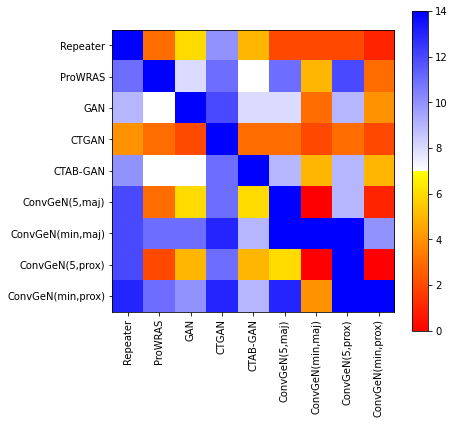

LR - cohens kappa score


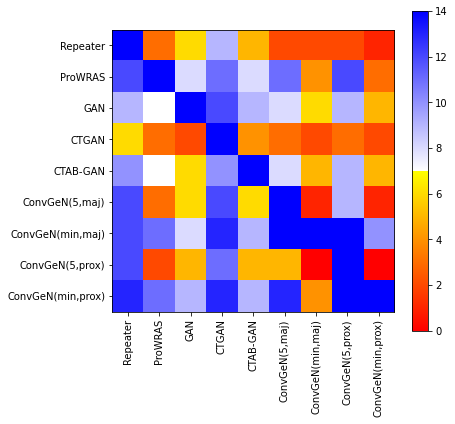

RF - f1 score


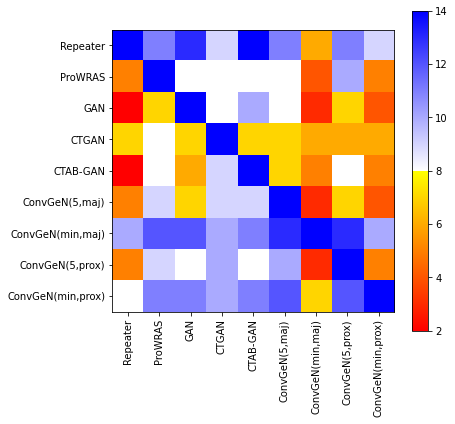

RF - cohens kappa score


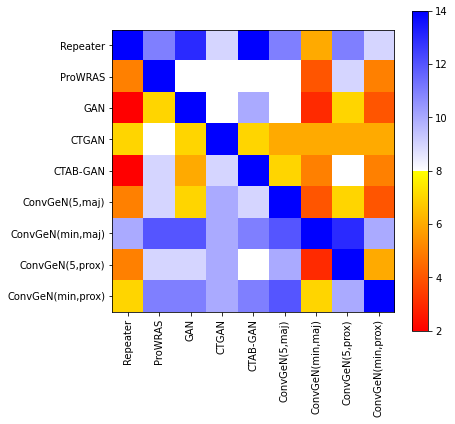

GB - f1 score


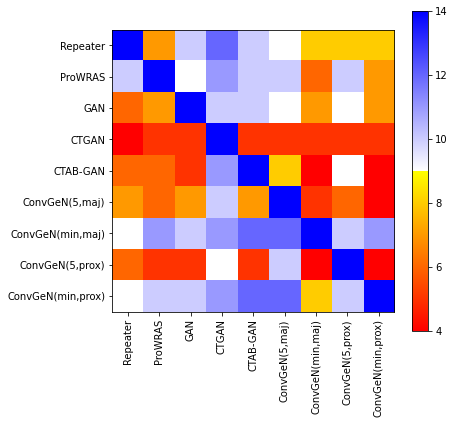

GB - cohens kappa score


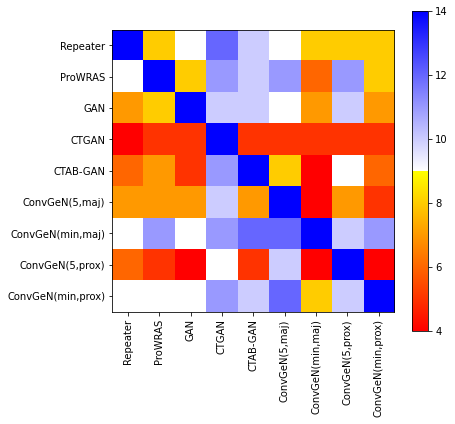

KNN - f1 score


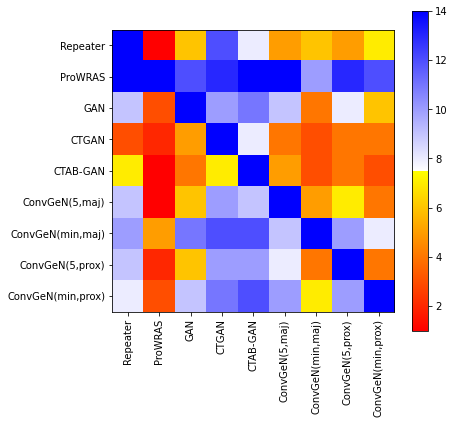

KNN - cohens kappa score


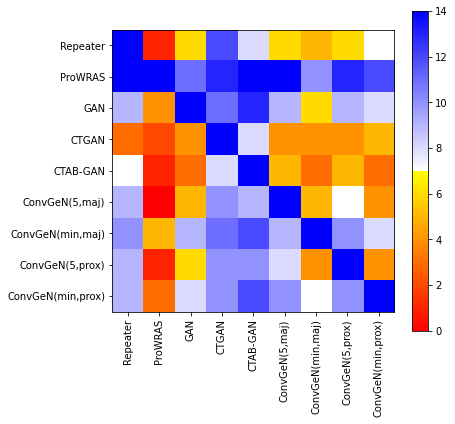

DoC - f1 score


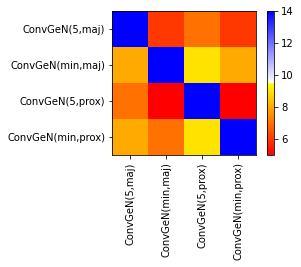

DoC - cohens kappa score


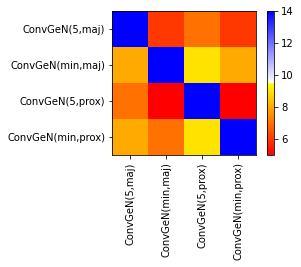

In [21]:
cmap = matplotlib.colors.ListedColormap([
    (1.0, x / 255.0, 0.0)
    for x in range(256)
    ] + [
    ((255 - x) / 255.0, (255 - x) / 255.0, 1.0) # x / 255.0)
    for x in range(256)
    ])

#cmap.set_extremes(bad=cmap(0.0), under=cmap(0.0), over=cmap(1.0))

for k in tables.keys():
    print(k)
    labels = list(gans)
    t = tables[k]
    if k[0:3] == "DoC":
        #continue
        labels = labels[-4:]
        t = [r[-4:] for r in t[-4:]]
        f = plt.figure(figsize=(5, 4))
        f.add_axes([0.4, 0.45, 0.6, 0.5])
    else:
        f = plt.figure(figsize=(7, 6))
        f.add_axes([0.27, 0.25, 0.7, 0.74])
    p = plt.imshow(t, cmap=cmap)
    plt.colorbar(p)
    plt.xticks(range(len(labels)), labels, rotation="vertical")
    plt.yticks(range(len(labels)), labels)
    plt.savefig(f"data_result/statistics/successCount/statistic-{k}.pdf")
    plt.show()

In [22]:
class Table:
    def __init__(self, heading):
        self.heading = [str(h) for h in heading]
        self.sizes = [len(h) for h in self.heading]
        self.rows = []
        
    def add(self, row):
        row = [str(r) for r in row]
        self.rows.append(row)
        self.sizes = [max(a,len(b)) for (a, b) in zip(self.sizes, row)]
        
    def separator(self):
        return "|".join(["-" * n for n in self.sizes])
    
    def showRow(self, row):
        def pad(n, t):
            while len(t) < n:
                t += " "
            return t
        
        return "|".join([pad(n, t) for (n,t) in zip(self.sizes, row)])
    
    def show(self):
        print(self.showRow(self.heading))
        print(self.separator())
        for row in self.rows:
            print(self.showRow(row))
            
    def showLatex(self, caption, key):
        
        columnConfig = "|".join(["l"] + ["@{\\hskip3pt}c@{\\hskip3pt}" for h in self.heading[1:]])

        text = "\\begin{table*}[ht]\\scriptsize"
        text += "\\caption{" + caption + "}\\label{" + key + "}"
        text += "\\centering\\tabularnewline\n"

        text += "\\begin{tabular}{" + columnConfig + "}\\hline\n"
        text += " & ".join(["\\textbf{" + h + "}" for h in self.heading])
        text += "\n\\tabularnewline\n\\hline\n"
        
        for row in self.rows:
            text += " & ".join(row)
            text += "\n\\tabularnewline\n"
            
        text += "\hline\end{tabular}\end{table*}\n"
        
        return text

In [23]:
def tableRow(algo, dataset, myGans):
    row = []
    for gan in myGans:
        v = getValueOf(gan, dataset, algo, f1Score)
        w = getValueOf(gan, dataset, algo, kScore)
        row.append((v, w))
    return row

In [24]:
def p(f, bold=False):
    if f is None:
        text = "?"
    else:
        text = f"{f:0.3f}"
        
    if bold:
        return " \\textbf{" + text + "} "
    else:
        return " " + text + " "

def latex(text):
    r = ""
    for x in text:
        if x == "_" or x == "-":
            r += " "
        else:
            r += x
    return r

def pairMax(row):
    a = 0.0
    b = 0.0
    
    for (x,y) in row:
        a = max(a, x)
        b = max(b, y)
    
    return (a, b)
    
with open("data_result/statistics/Tables.tex", "w") as latexFile:
    for algo in algs:
        latexFile.write("\n")
        latexFile.write("% ### " + algo + "\n")
        latexFile.write("\n")
        f = ""
        heading = ["dataset ($f_1~$score$~/~\\kappa~$score)"]
        
        myGans = gans
        if algo[0:3] == "DoC":
            myGans = list(gans)[-4:]

        for g in myGans:
            heading.append(latex(g))
        table = Table(heading)
        
        avg = [[0.0, 0.0] for h in heading[1:]]
        mx  = [[0.0, 0.0] for h in heading[1:]]
        cnt = 0

        for d in testSets:
            d = cleanupName(d)
            if d not in ignore:
                cnt += 1
                row = tableRow(algo, d, myGans)
                line = [latex(d)]

                m = pairMax(row)

                for (n, r) in enumerate(row):
                    line.append(f"{p(r[0], r[0] == m[0])} / {p(r[1], r[1] == m[1])}")
                    avg[n][0] += r[0] or 0.0
                    avg[n][1] += r[1] or 0.0
                    mx[n][0] = max(mx[n][0], r[0] or 0.0)
                    mx[n][1] = max(mx[n][1], r[1] or 0.0)
                table.add(line)

        m = pairMax(avg)
        table.add(["\\hline Average"] + [f"{p(a / cnt, a == m[0])} / {p(b / cnt, b == m[1])}" for (a,b) in avg])
        #table.add(["maximum"] + [f"{p(a)} / {p(b)}" for (a,b) in mx])

        tableB = None
        if len(table.heading) > 5:
            heading = [table.heading[0]] + table.heading[6:]
            tableB = Table(heading)
            tableB.sizes = [table.sizes[0]] + table.sizes[6:]
            tableB.rows = [
                [r[0]] + r[6:]
                for r in table.rows
                ]
            table.heading = table.heading[0:6]
            table.sizes = table.sizes[0:6]
            table.rows = [
                r[0:6]
                for r in table.rows
                ]

        if tableB is not None:
            latexFile.write(table.showLatex(algo + " (1)", "tab:results:" + algo + ":A") + "\n")
            latexFile.write("\n")
            latexFile.write(tableB.showLatex(algo + " (2)", "tab:results:" + algo + ":B") + "\n")
        else:
            latexFile.write(table.showLatex(algo, "tab:results:" + algo + ":A") + "\n")



In [25]:
for algo in algs:
    print("% ### " + algo)
    heading = ["dataset"]
    for g in gans:
        if filterConvGen(g):
            heading.append(g)
    table = []
    
    avg = [[0.0, 0.0] for h in heading[1:]]
    cnt = 0
    
    for d in testSets:
        d = cleanupName(d)
        if d not in ignore:
            cnt += 1
            row = tableRow(algo, d, heading[1:])
            table.append([(d,d)] + row)

            for (n, r) in enumerate(row):
                avg[n][0] += r[0] or 0.0
                avg[n][1] += r[1] or 0.0
    
    table.append([("Average", "Average")] + [(a / cnt, b / cnt) for (a,b) in avg])
    
    with open(f"data_result/statistics/{algo}-f1.csv", "w") as f:
        f.write((",".join(heading)) + "\n")
        for row in table:
            f.write((",".join([str(x[0]) for x in row])) + "\n")

    with open(f"data_result/statistics/{algo}-kappa.csv", "w") as f:
        f.write((",".join(heading)) + "\n")
        for row in table:
            f.write((",".join([str(x[1]) for x in row])) + "\n")


% ### LR
% ### RF
% ### GB
% ### KNN
% ### DoC


In [26]:
def dsWeight(d, score):
    w = 0.0
    for g in gans:
        for a in algs:
            x = getValueOf(g, d, a, score)
            if x is not None:
                w += x
    return w



dataNames = [cleanupName(d) for d in testSets]
dataNames.sort(key=lambda d: dsWeight(d, f1Score) + dsWeight(d, kScore))
for d in dataNames:
    w = dsWeight(d, f1Score) + dsWeight(d, kScore)
    print(f"{w:0.3f} - {d}")

5.480 - winequality-red-4
17.141 - flare-F
20.768 - abalone_17_vs_7_8_9_10
22.928 - yeast4
29.056 - abalone9-18
33.003 - yeast6
40.735 - car_good
49.689 - hypothyroid
51.936 - yeast5
57.451 - car-vgood
68.274 - kr-vs-k-zero-one_vs_draw
74.547 - kr-vs-k-three_vs_eleven
78.777 - shuttle-2_vs_5
79.641 - kddcup-guess_passwd_vs_satan
